In [1]:
# %pip install river==0.10.1
# %pip install pmdarima
# %pip install statsforecast
# %pip install -U scikit-multiflow
# %pip install pysr

In [2]:
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley
from plot import plot
import math
import time
import numpy as np
import random
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA as statsARIMA
import pysr
from collections.abc import Iterable

Pegando série e criando a árvore

In [3]:
from warnings import simplefilter
def clear_warns():
	simplefilter("ignore", category=RuntimeWarning)
	simplefilter("ignore", category=UserWarning)

Função que pega média e desvio padrão e diferença da soma das diferenças

In [4]:
def stats(series):
  desvio = np.std(series)
  media = np.mean(series)
  med_diff = np.mean(np.diff(series))
  return desvio, media, med_diff

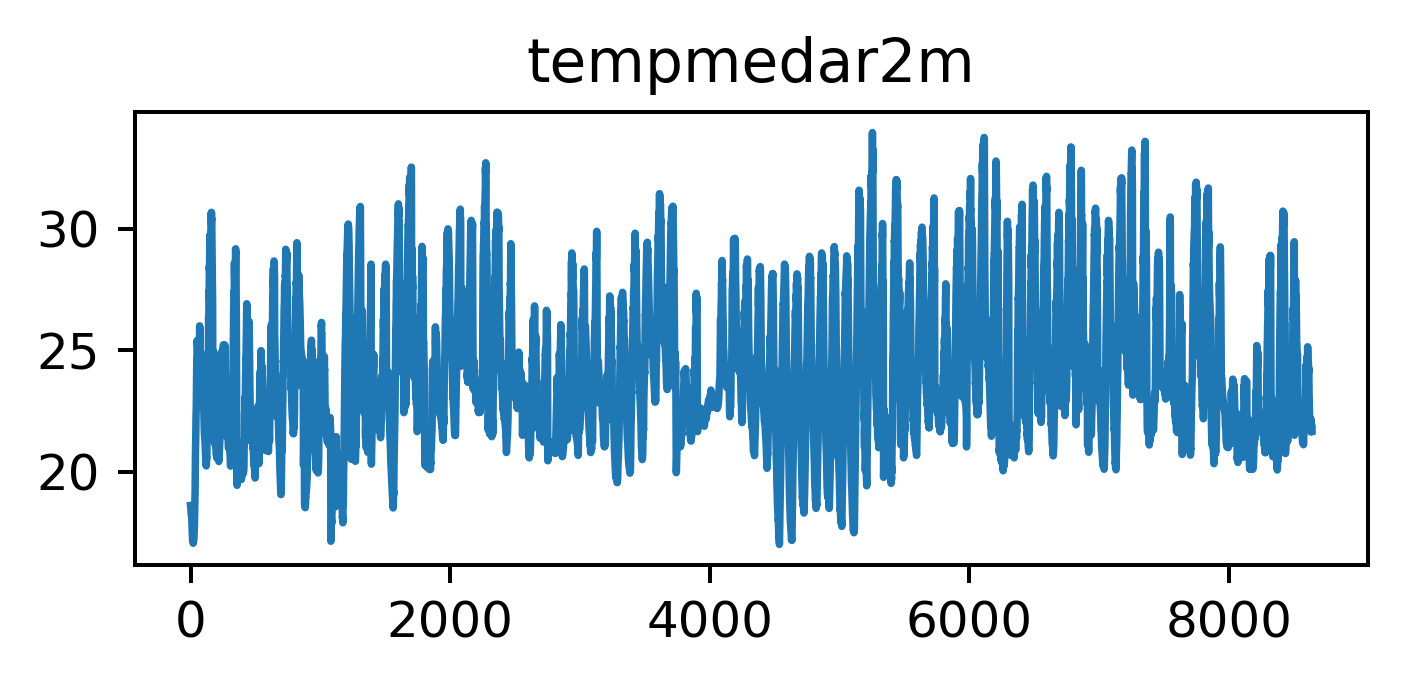

14.624247222282778
(-17.486122775620892, 4.462403415567287e-30, 24, 8615, {'1%': -3.4311092860745496, '5%': -2.861875553338115, '10%': -2.5669486101055368}, 9287.424480938014)
Criando splits
Não achei um corte, pegando melhor 437, 194.52574905270438, 2
Não achei um corte, pegando melhor 329, 194.52574905270438, 2
Não achei um corte, pegando melhor 281, 122.03722080415642, 2
Splits achados em 3.162095199993928: 


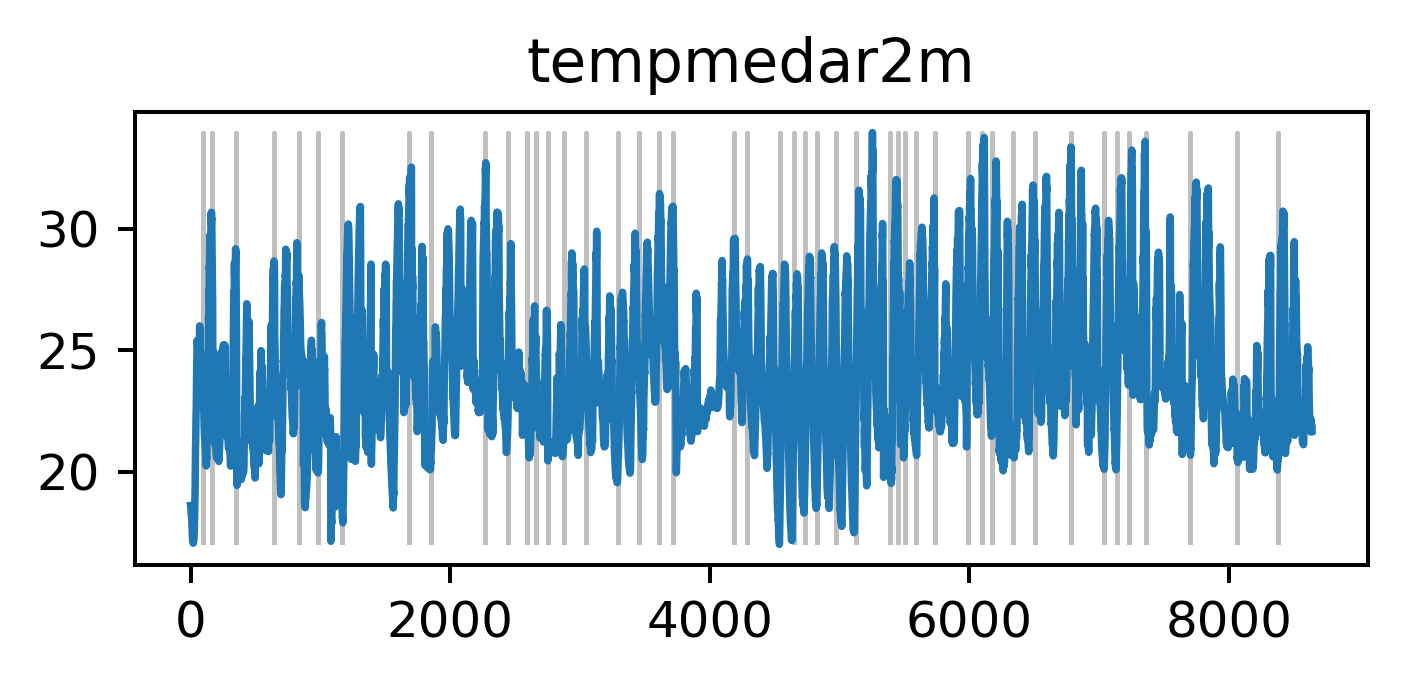

In [20]:
from statsmodels.tsa.stattools import adfuller
# series_path = '/content/drive/MyDrive/IDR-PR/Dados/por estacao/23025122/export_automaticas_23025122_tempsolocm40cm.csv'
feature = 'tempmedar2m'
# ventodir10m
series_path = f'../../../Dados/por estacao/23025122/export_automaticas_23025122_{feature}.csv'
clear_warns()

series_len = 90 * 96

series = pd.read_csv(series_path, nrows=series_len)

date_dict = {}
for i, date in enumerate(series.groupby(['date'])):
  date_dict[date[0]] = i

# series.head()
series['day'] = [date.split('-')[2] for date in series['date'].to_list()]
series['month'] = [date.split('-')[1] for date in series['date'].to_list()]
series['year'] = [date.split('-')[0] for date in series['date'].to_list()]
series['day_id'] = [date_dict[date] for date in series['date'].to_list()]
series['hour'] = [(int(int(h.split(':')[1])/15) + int(h.split(':')[0]) * 4) * 15 for h in series['hour'].to_list()]
series[feature] = series[feature].where(np.isfinite, series[feature].shift(fill_value=0))

adf = 0.05

plot(series[feature], title=feature)
adf_test = adfuller(series[feature])
print(adf_test[4][f'{int(adf*100)}%'] - adf_test[0])
print(adf_test)
print('Criando splits')

t = time.perf_counter()
xtstree = XTSTreePageHinkley(stop_condition='adf', stop_val=adf, min_dist=100, max_iter=100)

xtstree.create_splits(series[feature])
print(f'Splits achados em {time.perf_counter() - t}: ')
plot(series[feature], divisions=xtstree.cut_points(), title=feature)

In [21]:
series[7500:]

,id,date,hour,tempmedar2m,day,month,year,day_id
7500,1036063,2016-02-17,180,23.44,17,02,2016,78
7501,1024213,2016-02-17,195,23.33,17,02,2016,78
7502,1024214,2016-02-17,210,23.33,17,02,2016,78
7503,1024215,2016-02-17,225,23.60,17,02,2016,78
7504,1024216,2016-02-17,240,23.65,17,02,2016,78
...,...,...,...,...,...,...,...,...
8635,1050173,2016-02-28,1365,21.75,28,02,2016,89
8636,1050174,2016-02-28,1380,21.84,28,02,2016,89
8637,1061959,2016-02-28,1395,21.93,28,02,2016,89
8638,1061960,2016-02-28,1410,21.84,28,02,2016,89


Testes

Arima

In [14]:
from pmdarima.arima import ndiffs, nsdiffs
from statsforecast.arima import arima, AutoARIMA
from sklearn.metrics import mean_squared_error as mse

In [12]:
mse_perc = 0.4
def apply_arima(series):
  preds = AutoARIMA(period=96,
                    # d=ndiffs(series, test='adf'),
                    # D=nsdiffs(series, m=96),
                    stepwise=True
									).fit(series).predict_in_sample()['mean']
  err = mse(series[int(len(series)*(1-mse_perc)):], preds[int(len(preds)*(1-mse_perc)):])
  return list(preds), err

def seq_data(data, window_size=96):
  data_X = []
  data_Y = []
  for i in range(len(data) - (len(data) % window_size) - window_size):
    data_X.append(data[i:i+window_size])
    try:
      data_Y.append(data[i+window_size])
    except:
      (i+window_size)
  return np.array(data_X), np.array(data_Y)

In [13]:
print(f'Aplicando AutoARIMA na série toda')
t = time.perf_counter()
pred_full, _ = apply_arima(np.array(series[feature]))
print(f'AutoARIMA aplicado em {time.perf_counter() - t} segundos')

errs_full_by_cut = []
cut_points = [0] + xtstree.cut_points() + [len(series)]
for i, cut_pos in enumerate(cut_points):
  if i == 0:
    continue
  errs_full_by_cut.append(
    mse(
      series[feature][int(((cut_pos - cut_points[i-1])*(1-mse_perc)) + cut_points[i-1]):cut_pos],
      pred_full[int(((cut_pos - cut_points[i-1])*(1-mse_perc)) + cut_points[i-1]):cut_pos]
    )
  )


Aplicando AutoARIMA na série toda
AutoARIMA aplicado em 67.8164184000052 segundos


In [14]:
pred_cuts = []
errs_cuts_by_cut = []
print('Aplicando AutoARIMA nos cortes da árvore')
t = time.perf_counter()
for s in xtstree.cut_series(series[feature]):
  pred, err = apply_arima(np.array(s))
  pred_cuts = pred_cuts + pred
  errs_cuts_by_cut.append(err)
print(f'AutoARIMA aplicado em {time.perf_counter() - t} segundos')

Aplicando AutoARIMA nos cortes da árvore
AutoARIMA aplicado em 67.69302809998044 segundos


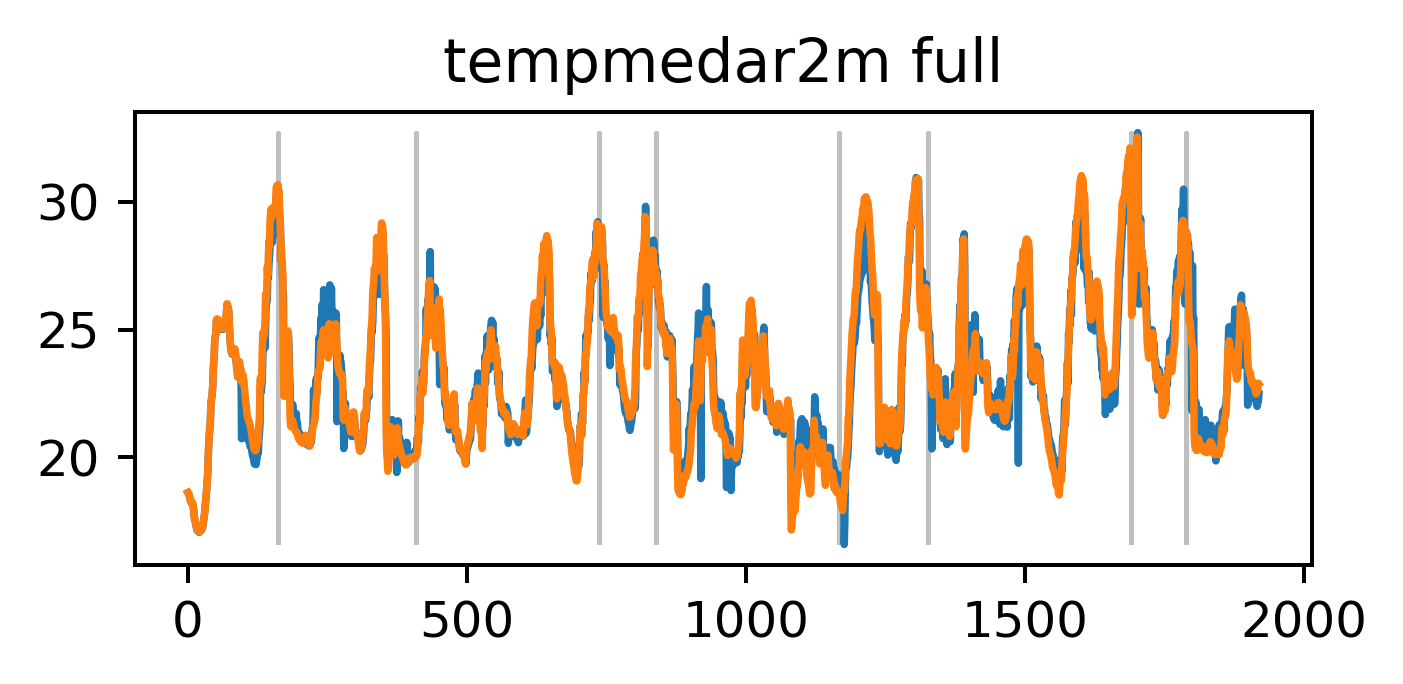

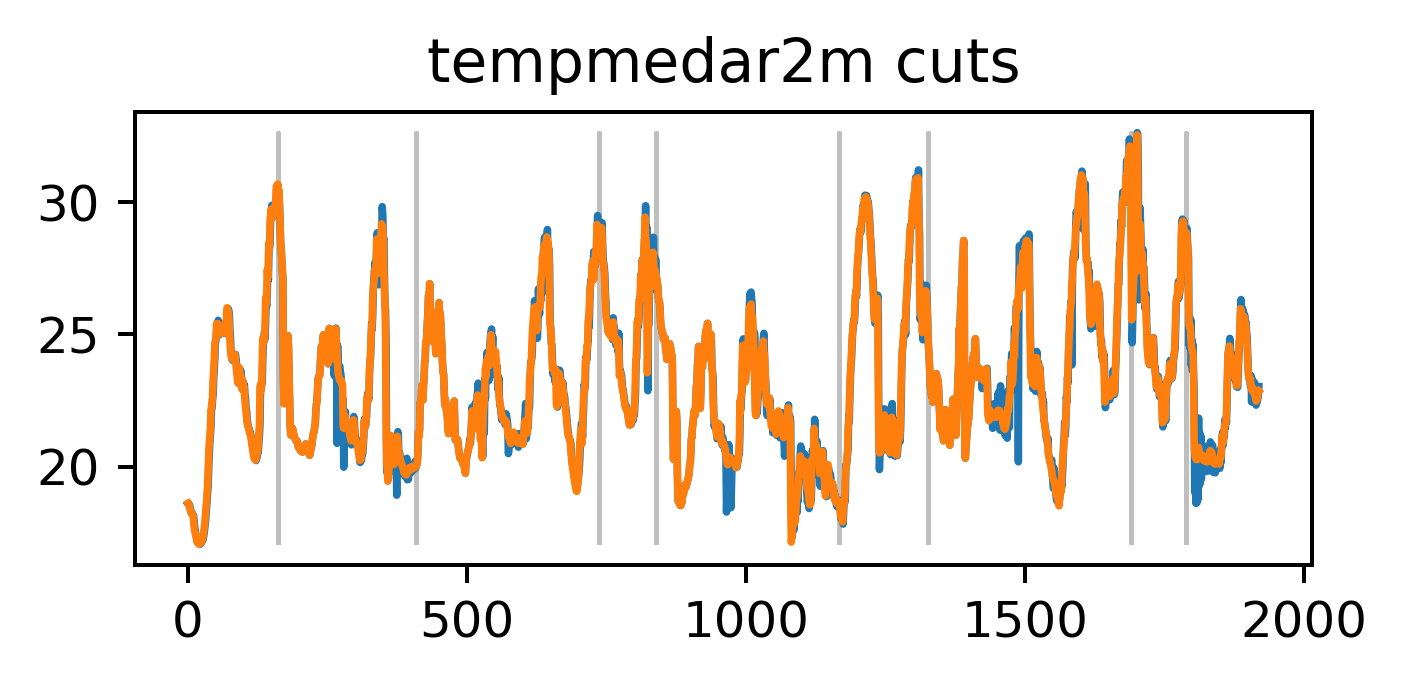

In [15]:
plot(pred_full, sec_plots=[series[feature]], title=f'{feature} full', divisions=xtstree.cut_points())
plot(pred_cuts, sec_plots=[series[feature]], title=f'{feature} cuts', divisions=xtstree.cut_points())

In [16]:
print(f'Erro nos últimos {mse_perc * 100}% de cada corte')
print('Erro dos cortes / Erro série completa')
print(list(zip(errs_cuts_by_cut,errs_full_by_cut)))

err_full = mse(series[feature][int(len(series)*(1-mse_perc)):], pred_full[int(len(pred_full)*(1-mse_perc)):])
err_cuts = mse(series[feature][int(len(series)*(1-mse_perc)):], pred_cuts[int(len(pred_cuts)*(1-mse_perc)):])
print('Erro total')
print(f'Erro cortes: {err_cuts}, Erro completa: {err_full}')

Erro nos últimos 40.0% de cada corte
Erro dos cortes / Erro série completa
[(0.15270880308416793, 0.633701178091539), (0.2559113605247332, 0.4025183479385981), (0.2074405699667729, 0.33837417830138933), (0.6377618255733277, 0.6090847265791343), (0.20614782008384788, 0.4859977705160424), (0.2573141879651289, 0.3788003285171761), (0.23531693403122617, 0.5916621480390448), (0.13462300599715465, 0.6518599776429631), (0.0655087325961081, 0.5596738070175559)]
Erro total
Erro cortes: 0.29194525932543497, Erro completa: 0.8179649879145656


Regressão Linear - Série toda e Divisões

In [5]:
def seq_data(data, window_size=96):
  data_X = []
  data_Y = []
  for i in range(len(data) - (len(data) % window_size) - window_size):
    data_X.append(data[i:i+window_size])
    try:
      data_Y.append(data[i+window_size])
    except:
      (i+window_size)
  return np.array(data_X), np.array(data_Y)


def sr_on_series(X: pd.DataFrame, y: Iterable):
  model = pysr.PySRRegressor(
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['neg', 'exp', 'abs', 'log', 'sqrt', 'sin'],
    progress=True,
    niterations=80,
    populations=25,
    population_size=50,
  )
  model.fit(X, y)
  return model 

In [81]:
X = series[['day_id', 'hour']]
y = series[feature]

print('SR na série toda')
t = time.perf_counter()
full_series_model = sr_on_series(X, y)
print('SR aplicado em ', time.perf_counter() - t)

print('SR nos cortes')
t = time.perf_counter()
cut_series = xtstree.cut_series(series)

cut_series_models = []

for s in cut_series:
	X = s[['day_id', 'hour']]
	y = s[feature]

	cut_series_models.append(sr_on_series(X, y))

print('SR aplicado em ', time.perf_counter() - t)

SR na série toda


NameError: name 'sr_on_series' is not defined

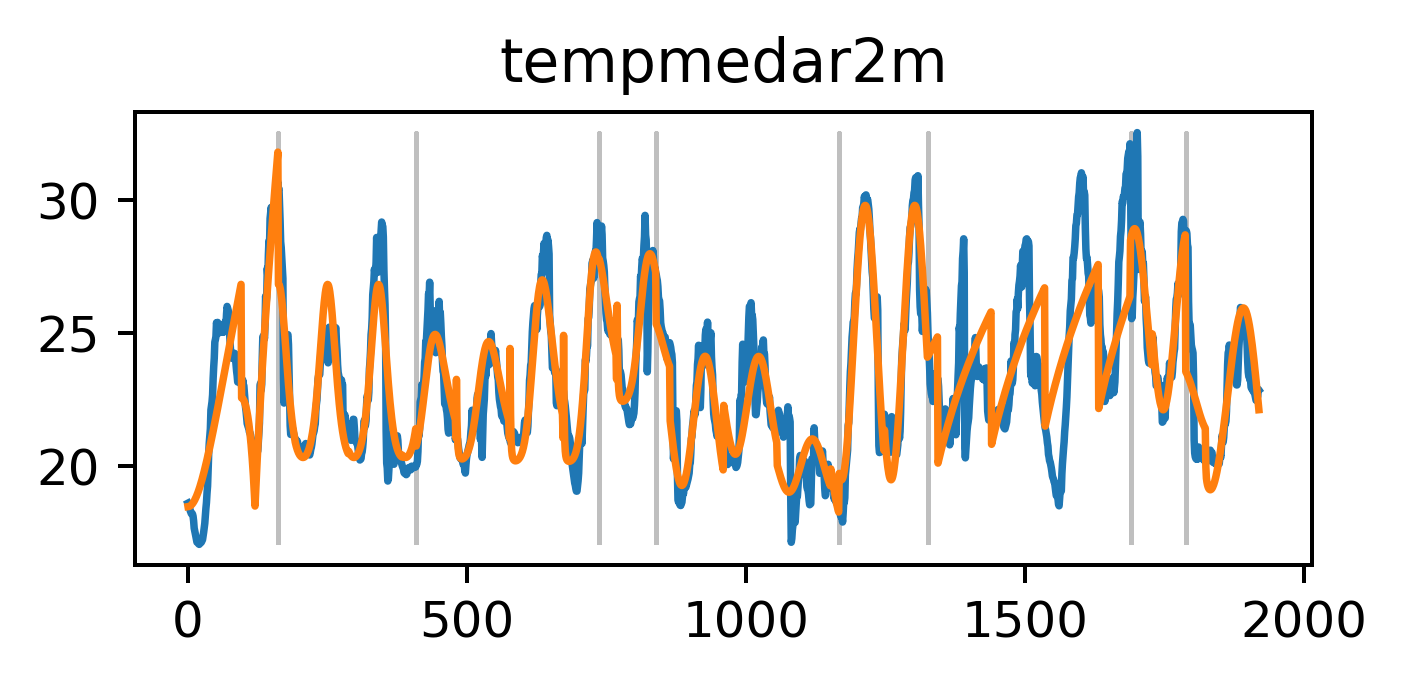

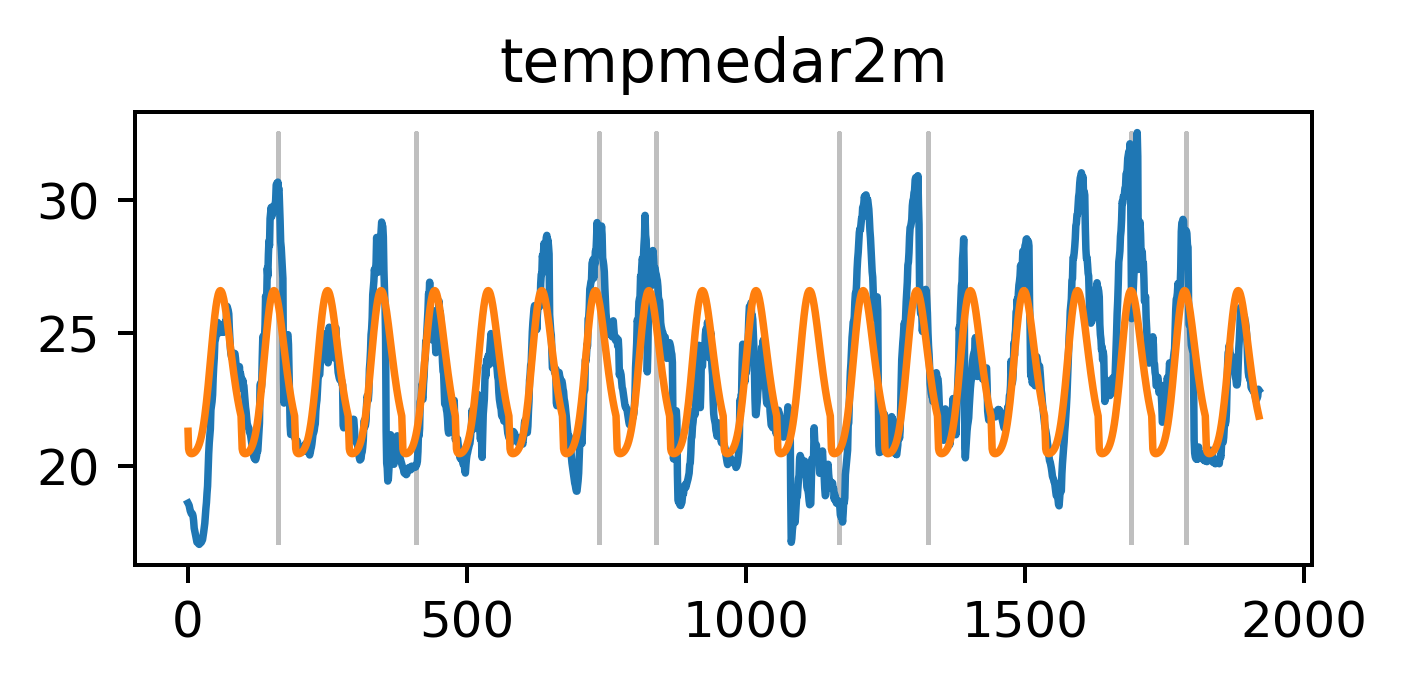

[PySRFunction(X=>18.4897459464802*(6.23145130625552e-7*Abs(1956968.2*date - hour**2*exp(exp(date))) + 1)**(1/4)), PySRFunction(X=>2.76631220706963*exp(sin(0.8330191*hour - 0.8330191*log(date))) + 19.317942), PySRFunction(X=>(date + sin(sqrt(exp(date))))**sin(hour**0.30393305) + 20.064524), PySRFunction(X=>exp(sin(hour**0.30321738))**1.7436154 + 22.272064), PySRFunction(X=>-date + sin(3.375193*date) - sin(0.84277236*hour)/Abs(sin(date)) + 31.572989), PySRFunction(X=>24.652216 - 5.15506034900274*sin(0.5363881*date + 0.0049350313*hour)), PySRFunction(X=>5.37818382717043*sqrt(date*sqrt(0.0011952463617896*hour + 1))), PySRFunction(X=>3.40291454185847*sin(103.835335989248*sqrt(9.27490895053756e-5*hour + 1)) + 25.528996), PySRFunction(X=>-sin(1.051061**(sqrt(hour)) - date)/Abs(sin(exp(date))) + 22.537704)]


In [19]:
full_series_pred = full_series_model.predict(series[['day_id', 'hour']])

cut_series_pred = np.concatenate([model.predict(series) for model, series in zip(cut_series_models, cut_series)])

plot(series[feature], sec_plots=[cut_series_pred], divisions=xtstree.cut_points(), title=feature)

plot(series[feature], sec_plots=[full_series_model.predict(series[['day_id', 'hour']])], divisions=xtstree.cut_points(), title=feature)

print([model.get_best()['lambda_format'] for model in cut_series_models])
# tree_pred_series = []
# err_mean = 0
# for pred, err in tree_predictions:
#   tree_pred_series += pred
#   err_mean += err

# err_mean = err_mean/len(tree_predictions)

In [6]:
# series_path = '/content/drive/MyDrive/IDR-PR/Dados/por estacao/23025122/export_automaticas_23025122_tempsolocm40cm.csv'
feature = 'tempmedar2m'
# ventodir10m
series_path = f'../../../Dados/por estacao/23025122/export_automaticas_23025122_{feature}.csv'
series_full = pd.read_csv(series_path)

date_dict = {}
for i, date in enumerate(series_full.groupby(['date'])):
  date_dict[date[0]] = i

series_full['day'] = [int(date.split('-')[2]) for date in series_full['date'].to_list()]
series_full['month'] = [int(date.split('-')[1]) for date in series_full['date'].to_list()]
series_full['year'] = [int(date.split('-')[0]) for date in series_full['date'].to_list()]
series_full['day_id'] = [date_dict[date] for date in series_full['date'].to_list()]
series_full['hour'] = [(int(int(h.split(':')[1])/15) + int(h.split(':')[0]) * 4) * 15 for h in series_full['hour'].to_list()]
series_full[feature] = series_full[feature].where(np.isfinite, series_full[feature].shift(fill_value=0))

In [ ]:
mes = 3
ano = 2017
adf = 0.05

past_month_series = series_full.loc[(series_full['month'] == mes) & (series_full['year'] == ano) & (series_full['day'] <= 20)]

past_month_series = past_month_series.reset_index()

print('Criando splits')

t = time.perf_counter()
xtstree = XTSTreePageHinkley(stop_condition='adf', stop_val=adf, min_dist=100, max_iter=100)

xtstree.create_splits(past_month_series[feature])
print(f'Splits achados em {time.perf_counter() - t}: ')
plot(past_month_series[feature], divisions=xtstree.cut_points(), title=feature)
X = past_month_series[['day', 'month', 'hour']]
y = past_month_series[feature]

print('SR na série toda')
t = time.perf_counter()
full_series_model = sr_on_series(X, y)
print('SR aplicado em ', time.perf_counter() - t)

print('SR nos cortes')
t = time.perf_counter()
cut_series = xtstree.cut_series(past_month_series)

cut_series_models = []

for s in cut_series:
	X = s[['day', 'month', 'hour']]
	y = s[feature]

	cut_series_models.append(sr_on_series(X, y))

print('SR aplicado em ', time.perf_counter() - t)

# tree_pred_series = []
# err_mean = 0
# for pred, err in tree_predictions:
#   tree_pred_series += pred
#   err_mean += err

# err_mean = err_mean/len(tree_predictions)

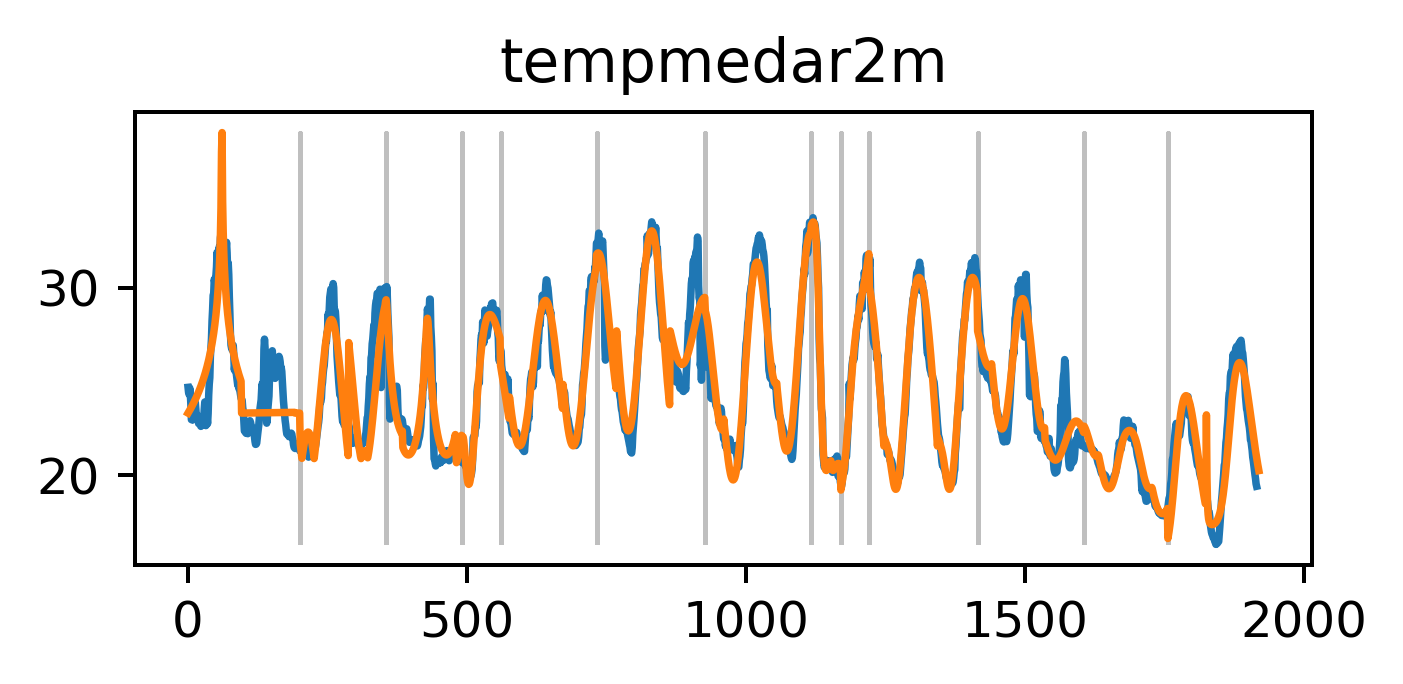

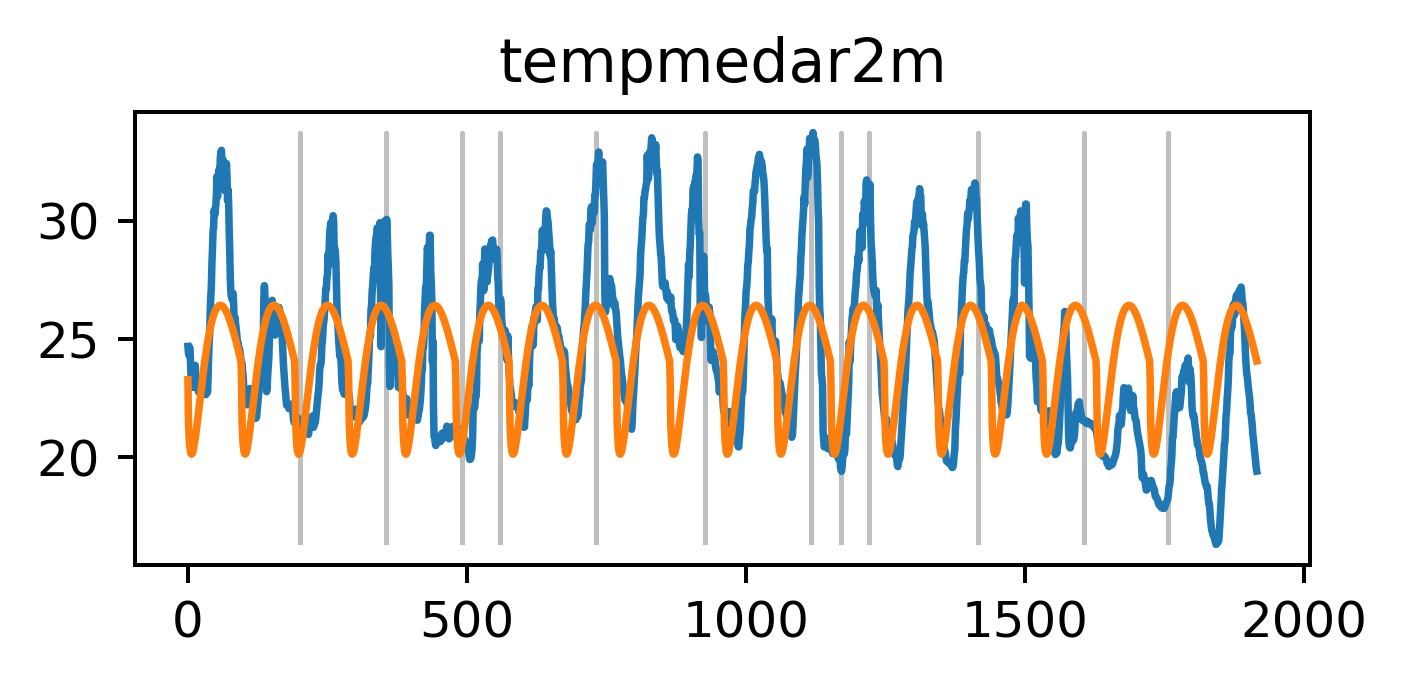

[PySRFunction(X=>29.3618063 - log(Abs(0.00824959**day*hour - 7.4969726)**month)), PySRFunction(X=>Abs(day + 4.4208317*sin(0.005011401*3.1896405**day - 0.005011401*hour)) + 20.885946), PySRFunction(X=>-day - 1.90444025387179*log(1.0446037 - sin(day - Abs(day - 0.83162564*hour))) + 27.44875963), PySRFunction(X=>hour**0.1633389*(1.41008493308174*day + sin(3.9754093*log(hour)))), PySRFunction(X=>day - (day - 3.1256564)*sin(0.004530478*hour + 0.33417082) + 18.447712), PySRFunction(X=>-(3.3151808 + 0.83039576/sin(day))*sin(0.004992593*hour) + 27.69836), PySRFunction(X=>2*day + 0.004460519*hour - sin(day) - 4.4505797169369*sin(0.005470043*hour)), PySRFunction(X=>26.880907 - 6.62136023000487*sin(2.2700634*sin(sin(1.2616376*hour + 0.5735861)))), PySRFunction(X=>5.03743465677937*sqrt(0.029673785*hour + sin(0.5446988*sqrt(hour))) + 4.5564833), PySRFunction(X=>0.0097330455*hour*sin(log(hour**month + 9612964.0) + 0.23218882) + 21.982042), PySRFunction(X=>-2.5627077*day + (sin(1.6698612*hour) + 0.62

In [11]:
full_series_pred_2017 = full_series_model.predict(past_month_series[['day', 'month', 'hour']])

cut_series_pred_2017 = np.concatenate([model.predict(series) for model, series in zip(cut_series_models, cut_series)])

plot(past_month_series[feature], sec_plots=[cut_series_pred_2017], divisions=xtstree.cut_points(), title=feature)

plot(past_month_series[feature], sec_plots=[full_series_pred_2017], divisions=xtstree.cut_points(), title=feature)

print([model.get_best()['lambda_format'] for model in cut_series_models])

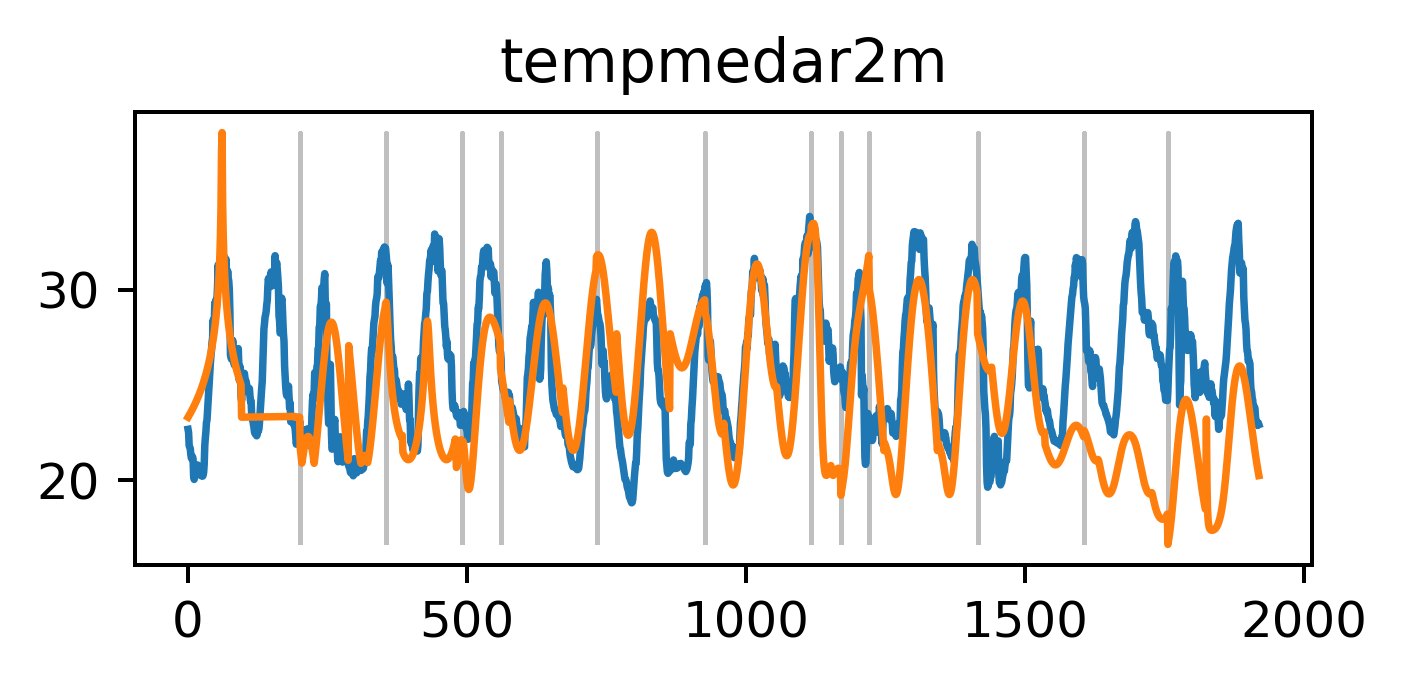

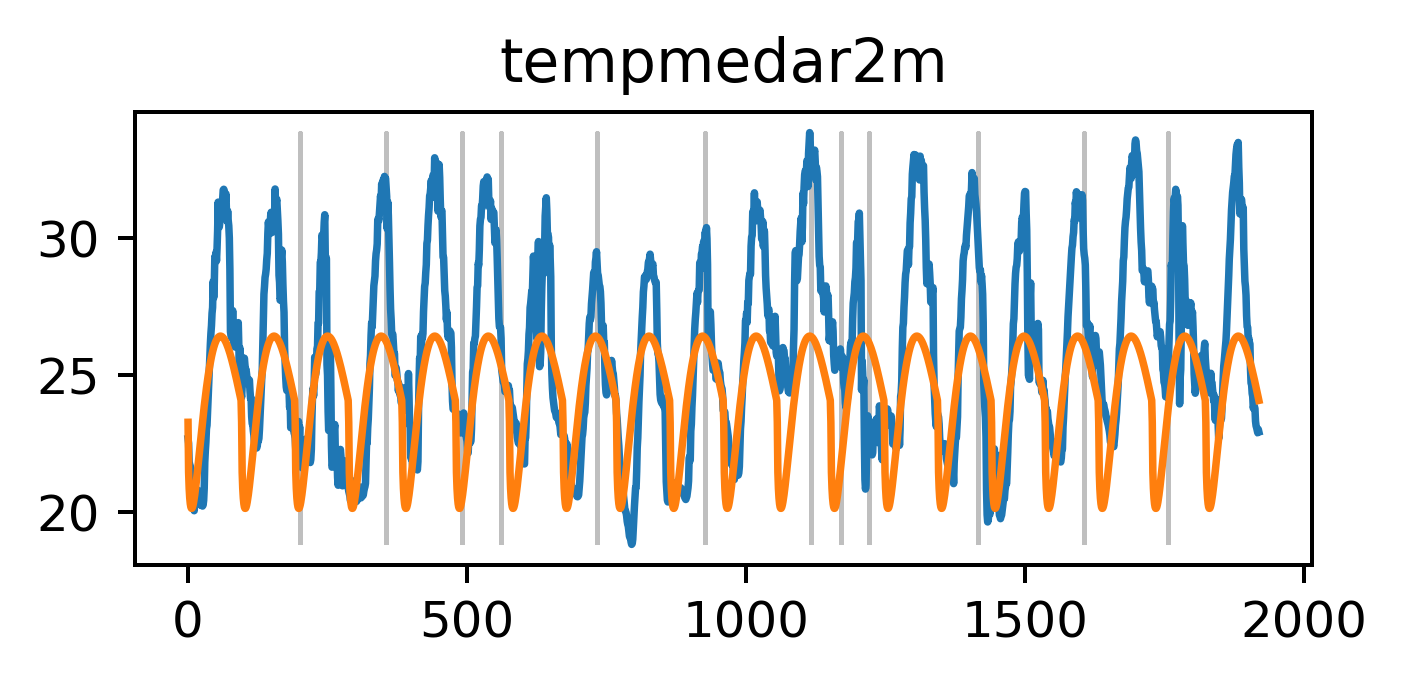

[PySRFunction(X=>29.3618063 - log(Abs(0.00824959**day*hour - 7.4969726)**month)), PySRFunction(X=>Abs(day + 4.4208317*sin(0.005011401*3.1896405**day - 0.005011401*hour)) + 20.885946), PySRFunction(X=>-day - 1.90444025387179*log(1.0446037 - sin(day - Abs(day - 0.83162564*hour))) + 27.44875963), PySRFunction(X=>hour**0.1633389*(1.41008493308174*day + sin(3.9754093*log(hour)))), PySRFunction(X=>day - (day - 3.1256564)*sin(0.004530478*hour + 0.33417082) + 18.447712), PySRFunction(X=>-(3.3151808 + 0.83039576/sin(day))*sin(0.004992593*hour) + 27.69836), PySRFunction(X=>2*day + 0.004460519*hour - sin(day) - 4.4505797169369*sin(0.005470043*hour)), PySRFunction(X=>26.880907 - 6.62136023000487*sin(2.2700634*sin(sin(1.2616376*hour + 0.5735861)))), PySRFunction(X=>5.03743465677937*sqrt(0.029673785*hour + sin(0.5446988*sqrt(hour))) + 4.5564833), PySRFunction(X=>0.0097330455*hour*sin(log(hour**month + 9612964.0) + 0.23218882) + 21.982042), PySRFunction(X=>-2.5627077*day + (sin(1.6698612*hour) + 0.62

In [12]:
mes = 3
ano = 2018

next_year_month_series = series_full.loc[(series_full['month'] == mes) & (series_full['year'] == ano) & (series_full['day'] <= 20)]

next_year_month_series = next_year_month_series.reset_index()

cut_series_2018 = xtstree.cut_series(next_year_month_series)

full_series_pred_2018 = full_series_model.predict(next_year_month_series[['day', 'month', 'hour']])

cut_series_pred_2018 = np.concatenate([model.predict(series) for model, series in zip(cut_series_models, cut_series)])

plot(next_year_month_series[feature], sec_plots=[cut_series_pred_2018], divisions=xtstree.cut_points(), title=feature)

plot(next_year_month_series[feature], sec_plots=[full_series_pred_2018], divisions=xtstree.cut_points(), title=feature)

print([model.get_best()['lambda_format'] for model in cut_series_models])

In [18]:
len(cut_series_pred_2017)

1920

In [28]:
print('Erro normal 2017')
print(mse(past_month_series[feature], full_series_pred_2017))
print('Erro xtstree 2017')
print(mse(past_month_series[feature], cut_series_pred_2017[:-4]))
print('Erro normal 2018')
print(mse(next_year_month_series[feature], full_series_pred_2018))
print('Erro xtstree 2018')
print(mse(next_year_month_series[feature], cut_series_pred_2018))

Erro normal 2017
9.15900026983668
Erro xtstree 2017
1.3951782886904796
Erro normal 2018
9.55819885695202
Erro xtstree 2018
16.75723539230159
